In [148]:
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
import io
import cv2  # Optional (if you prefer OpenCV)
import json
import os
import torch
from torch.utils.data import Dataset
from transformers import TrOCRProcessor,VisionEncoderDecoderModel,Seq2SeqTrainer, Seq2SeqTrainingArguments, default_data_collator
from torchvision import transforms
from datasets import load_metric
from torch.cuda import is_available as cuda_available
from torchvision.transforms import ToTensor


In [108]:
#Reading the training and testing data
train_df = pd.read_csv('../data/processed/MMF_HAR_comb_processed/training/mmf_har_train_combined.csv')
test_df = pd.read_csv('../data/processed/MMF_HAR_comb_processed/testing/mmf_har_test_combined.csv')

print(train_df.head())
print(test_df.head())
print(train_df.columns)
print(test_df.columns)

         image                                               text
0  X2dmDrp.png  `` Chelsea Clinton steps out of college and he...
1  rOvVkF1.png  o 28 % 1:19 PM 76 AT & T M-Cell Details Dad Me...
2  m4oY5vK.png  On 1-20-2017 What is the first thing you want ...
3  Okb6dJB.png  N Dallas , Texas 10:31 AM CT DALLAS TRUMP VS ....
4  4KXGjz0.png  `` One thing ca n't stand is the military . It...
         image                                               text
0  12XLnzK.png  thewrap.com SUICIDE `` Suicide Squad ' Executi...
1  VAJZJJV.png  3 hrs This was in my Facebook feed this mornin...
2  zvdzU3y.png  Bernie or Hillary ? Be informed . Compare them...
3  qi0bYgG.png  WE 'RE FUCKED , MOVE TO CANADA I STILL FEEL YO...
4  NpsCjMn.png  SAYS BERNIE SANDERS SUPPORTERS ARE LAZY AND UN...
Index(['image', 'text'], dtype='object')
Index(['image', 'text'], dtype='object')


In [140]:

class MMF_HAR(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=32):
        self.root_dir = root_dir
        self.df = df.reset_index(drop=True)  # Important after splits
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get data from dataframe
        image_name = self.df.iloc[idx]['image']
        text = self.df.iloc[idx]['text']
        
        # Load and process image
        image_path = os.path.join(self.root_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # Process text
        labels = self.processor.tokenizer(
            text,
            padding="max_length",
            max_length=self.max_target_length,
            truncation=True
        ).input_ids
        
        # Replace padding token with -100
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 
                 for label in labels]

        return {
            "pixel_values": pixel_values.squeeze(),
            "labels": torch.tensor(labels)
        }


In [121]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

train_dataset = MMF_HAR(root_dir='../data/processed/MMF_HAR_comb_processed/images/training/',
                           df=train_df,
                           processor=processor)
eval_dataset = MMF_HAR(root_dir='../data/processed/MMF_HAR_comb_processed/images/testing/',
                           df=test_df,
                           processor=processor)

c:\Users\Mert\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [122]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 3429
Number of validation examples: 858


Let's verify an example from the training dataset:

In [123]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([64])


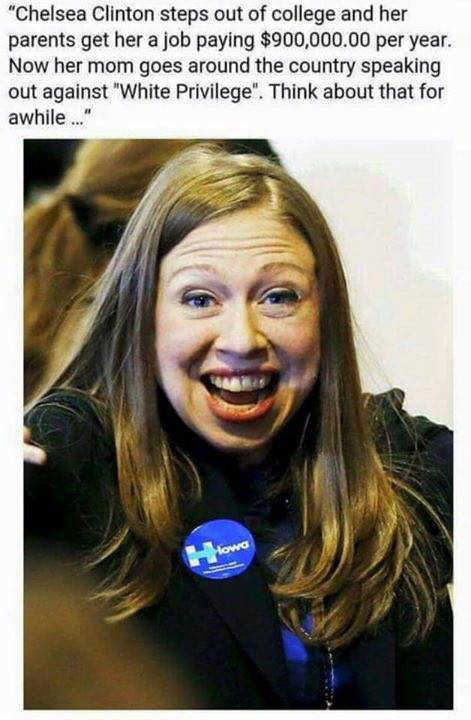

In [125]:
image = Image.open(train_dataset.root_dir + train_df['image'][0]).convert("RGB")
image

In [128]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

`` Chelsea Clinton steps out of college and her parents get her a job paying $ 900,000.00 per year. Now her mom goes around the country speaking out against `` White Privilege ''. Think about that for awhile 


## **Train the model**

Here, we initialize the TrOCR model from its pretrained weights. Note that the weights of the language modeling head are already initialized from pre-training, as the model was already trained to generate text during its pre-training stage. Refer to the paper for details.

In [132]:
def load_model_with_check(model_name="microsoft/trocr-base-stage1", local_path="./saved_model"):
    # Create directory if it doesn't exist
    os.makedirs(local_path, exist_ok=True)
    
    try:
        # Try to load from local
        model = VisionEncoderDecoderModel.from_pretrained(local_path)
        processor = TrOCRProcessor.from_pretrained(local_path)
        print("Loaded model and processor from local storage")
        return model, processor
    except:
        # Download if local load fails
        print("Downloading model and processor...")
        model = VisionEncoderDecoderModel.from_pretrained(model_name)
        processor = TrOCRProcessor.from_pretrained(model_name)
        
        # Save for future use
        model.save_pretrained(local_path)
        processor.save_pretrained(local_path)
        print("Saved model and processor to local storage")
        return model, processor

# Usage
model, processor = load_model_with_check()

Loaded model and processor from local storage


Importantly, we need to set a couple of attributes, namely:
* the attributes required for creating the `decoder_input_ids` from the `labels` (the model will automatically create the `decoder_input_ids` by shifting the `labels` one position to the right and prepending the `decoder_start_token_id`, as well as replacing ids which are -100 by the pad_token_id)
* the vocabulary size of the model (for the language modeling head on top of the decoder)
* beam-search related parameters which are used when generating text.

In [134]:
# Text Generation Strategy
model.config.max_length = 32  # Memes are rarely >30 words
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 2  # Allow some repetition
model.config.length_penalty = 0.8  # Prefer shorter texts
model.config.num_beams = 5  # More creative variations

# Ensure token alignment
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.vocab_size = model.config.decoder.vocab_size

# Optional: Temperature for sampling
model.config.temperature = 0.9  # More creative outputs
model.config.do_sample = True  # Enable sampling

Next, we can define some training hyperparameters by instantiating the `training_args`. Note that there are many more parameters, all of which can be found in the [documentation](https://huggingface.co/transformers/main_classes/trainer.html#seq2seqtrainingarguments). You can for example decide what the batch size is for training/evaluation, whether to use mixed precision training (lower memory), the frequency at which you want to save the model, etc.

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./trocr-meme-model",
    evaluation_strategy="steps",
    # Device optimization
    fp16=cuda_available(),  # Only enable if CUDA is available
    # Adjusted steps for 3500 training samples
    per_device_train_batch_size=8 if cuda_available() else 2,
    per_device_eval_batch_size=8 if cuda_available() else 2,
    eval_steps=100,
    save_steps=200,
    # Training parameters
    learning_rate=3e-5,
    num_train_epochs=15,
    warmup_steps=50,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    # Generation & metrics
    predict_with_generate=True,
    generation_max_length=32,  # Match meme text length
    # Model saving
    load_best_model_at_end=True,
    metric_for_best_model="cer",
    greater_is_better=False,
    # Logging
    logging_steps=20,
    save_total_limit=2,
    report_to="none"  # Disable wandb if not needed
)

We will evaluate the model on the Character Error Rate (CER), which is available in HuggingFace Datasets (see [here](https://huggingface.co/metrics/cer)).

In [138]:
cer_metric = load_metric("cer")

C:\Users\Mert\AppData\Local\Temp\ipykernel_13612\4287149634.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer")
c:\Users\Mert\anaconda3\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for cer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/cer/cer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


The compute_metrics function takes an `EvalPrediction` (which is a NamedTuple) as input, and should return a dictionary. The model will return an EvalPrediction at evaluation, which consists of 2 things:
* predictions: the predictions by the model.
* label_ids: the actual ground-truth labels.

In [139]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

Let's train! We also provide the `default_data_collator` to the Trainer, which is used to batch together examples.

Note that evaluation takes quite a long time, as we're using beam search for decoding, which requires several forward passes for a given example.

In [143]:
#Define Augmentations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # ±10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=(3,7), sigma=(0.1, 0.5))
])

In [149]:
# Modify Dataset Class
class AugmentedMMFHAR(MMF_HAR):
    def __init__(self, root_dir, df, processor, transform=None, **kwargs):
        super().__init__(root_dir, df, processor, **kwargs)
        self.transform = transform
        
    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        
        # Apply augmentations only to training images
        if self.transform:
            image = transforms.ToPILImage()(item["pixel_values"])
            item["pixel_values"] = transforms.ToTensor()(self.transform(image))
            
        return item


In [150]:
#Create Augmented Datasets
train_dataset = AugmentedMMFHAR(
    root_dir='../data/processed/MMF_HAR_comb_processed/images/training/',
    df=train_df,
    processor=processor,
    transform=train_transform,
    max_target_length=32
)

eval_dataset = AugmentedMMFHAR(  # No augmentations for eval
    root_dir='../data/processed/MMF_HAR_comb_processed/images/testing/',
    df=test_df,
    processor=processor,
    transform=None, 
    max_target_length=32
)

In [151]:
# Update Trainer with Custom Collator
def augmented_collator(batch):
    to_tensor = ToTensor()  # Create converter inside collator
    
    # Convert all images to tensors
    pixel_values = torch.stack([
        item["pixel_values"] if torch.is_tensor(item["pixel_values"]) 
        else to_tensor(item["pixel_values"]) 
        for item in batch
    ])
    
    labels = torch.stack([item["labels"] for item in batch])
    return {"pixel_values": pixel_values, "labels": labels}

# Instantiate Trainer with Augmentations
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=augmented_collator,  # Use custom collator
)

In [152]:
trainer.train()

  0%|          | 0/6420 [00:00<?, ?it/s]

KeyboardInterrupt: 